## BUONO


🔍 Decision Tree
Best Params: {'max_depth': 7, 'min_samples_leaf': 1}
Train Accuracy: 0.9752
Test Accuracy: 0.9720
AUC-ROC (Multiclass): 0.9909
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.91      0.94       108
           1       0.94      0.97      0.95       442
           2       0.99      0.98      0.98       950

    accuracy                           0.97      1500
   macro avg       0.97      0.95      0.96      1500
weighted avg       0.97      0.97      0.97      1500



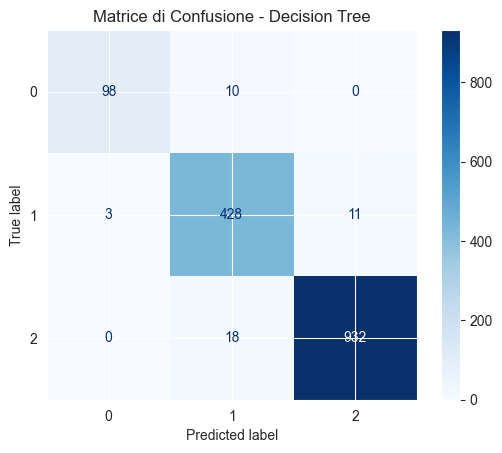

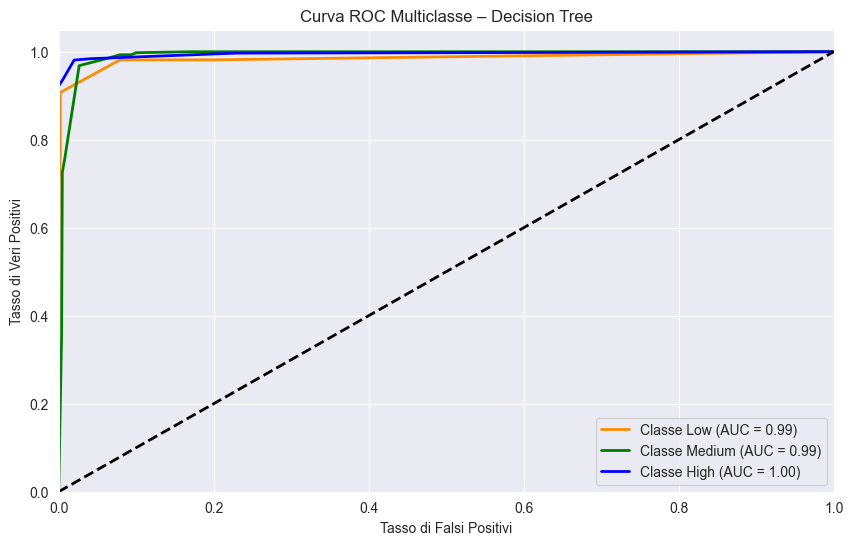


🔍 Random Forest
Best Params: {'max_depth': 10, 'n_estimators': 50}
Train Accuracy: 0.9931
Test Accuracy: 0.9773
AUC-ROC (Multiclass): 0.9990
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95       108
           1       0.96      0.97      0.96       442
           2       0.99      0.98      0.99       950

    accuracy                           0.98      1500
   macro avg       0.96      0.97      0.97      1500
weighted avg       0.98      0.98      0.98      1500



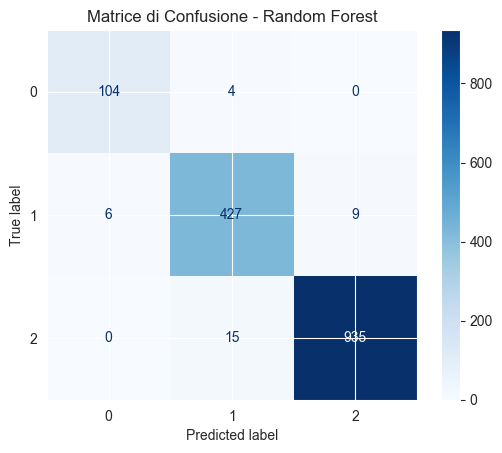

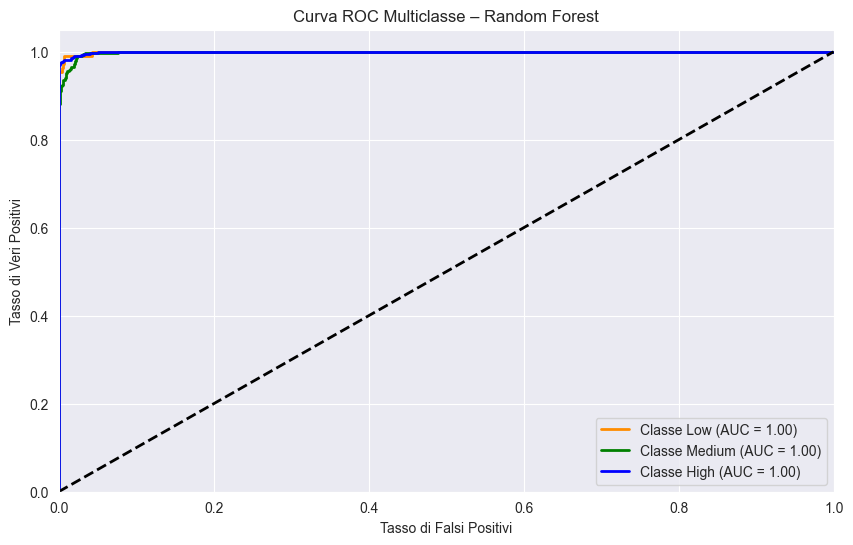


🔍 Logistic Regression
Best Params: {'C': 10}
Train Accuracy: 0.8165
Test Accuracy: 0.7520
AUC-ROC (Multiclass): 0.8998
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.93      0.75       108
           1       0.57      0.70      0.63       442
           2       0.90      0.76      0.82       950

    accuracy                           0.75      1500
   macro avg       0.70      0.79      0.73      1500
weighted avg       0.78      0.75      0.76      1500



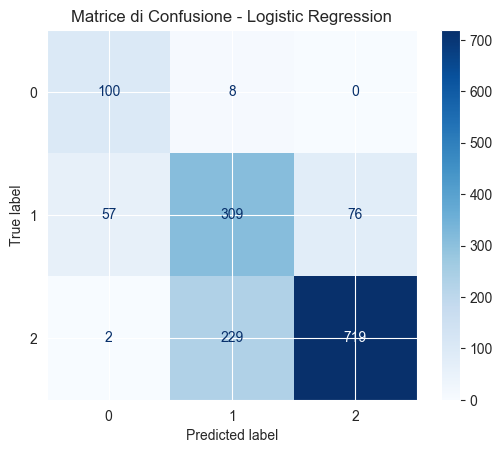

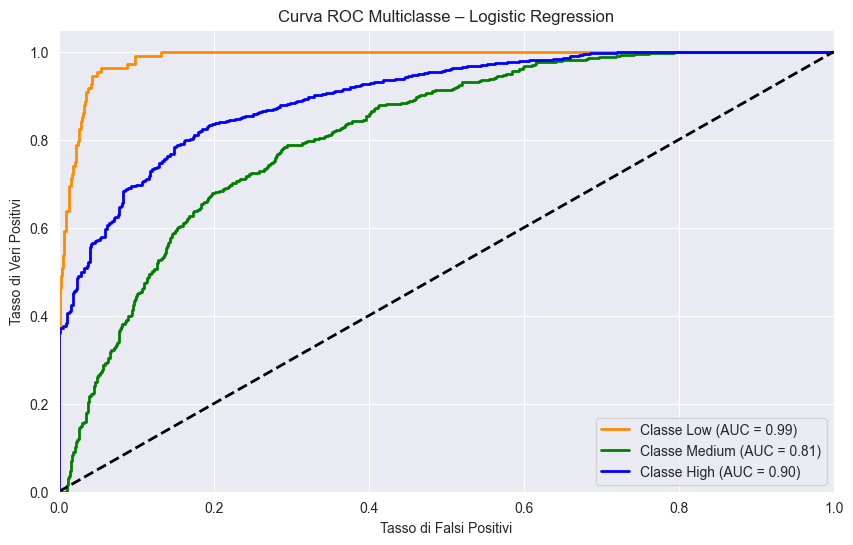


🔍 KNN
Best Params: {'n_neighbors': 3}
Train Accuracy: 0.9335
Test Accuracy: 0.7767
AUC-ROC (Multiclass): 0.9091
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.94      0.70       108
           1       0.61      0.76      0.68       442
           2       0.95      0.77      0.85       950

    accuracy                           0.78      1500
   macro avg       0.71      0.82      0.74      1500
weighted avg       0.82      0.78      0.79      1500



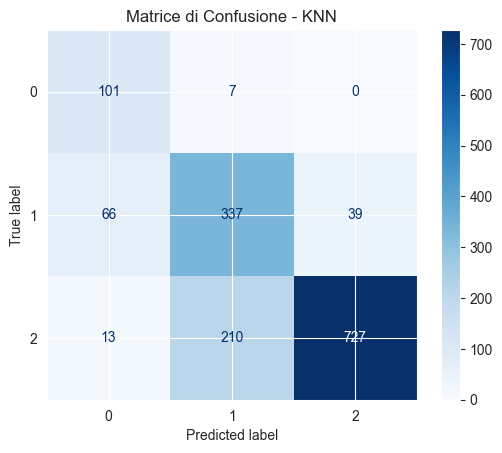

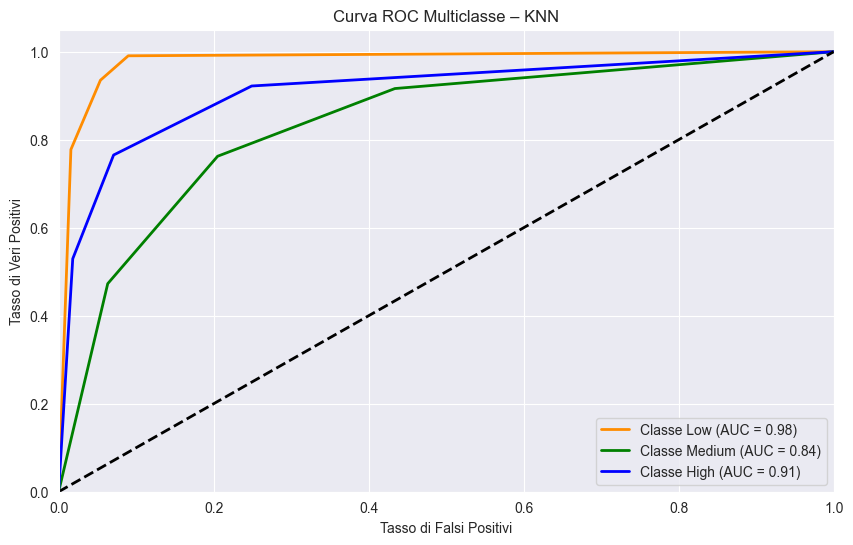

In [ ]:
# 📦 Import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, label_binarize
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    ConfusionMatrixDisplay, roc_auc_score
)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from imblearn.over_sampling import SMOTE

# Classificatori
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# 🔹 1. LETTURA DEL DATASET
dataset = pd.read_csv("smart_mobility_dataset.csv")

# 🔹 2. FEATURE ENGINEERING
encoder = LabelEncoder()

# Mappatura personalizzata per il target
dataset['Traffic_Condition'] = dataset['Traffic_Condition'].map({'Low': 0, 'Medium': 1, 'High': 2})

# Label encoding su altre categorie
for col in ['Traffic_Light_State', 'Weather_Condition']:
    dataset[col] = encoder.fit_transform(dataset[col])

# Timestamp ➝ ora ➝ fascia oraria ➝ encoding
dataset['Timestamp'] = pd.to_datetime(dataset['Timestamp'])
dataset['Time_of_Day'] = dataset['Timestamp'].dt.hour.apply(
    lambda h: 'Morning' if 6 <= h < 12 else 'Afternoon' if 12 <= h < 18 else 'Evening' if 18 <= h < 24 else 'Night'
)
dataset['Time_of_Day'] = encoder.fit_transform(dataset['Time_of_Day'])
dataset.drop(columns=['Timestamp'], inplace=True)

# Congestion Index
scaler = MinMaxScaler()
dataset[['Vehicle_Count', 'Traffic_Speed_kmh', 'Road_Occupancy_%']] = scaler.fit_transform(
    dataset[['Vehicle_Count', 'Traffic_Speed_kmh', 'Road_Occupancy_%']]
)
dataset['Congestion_Index'] = 0.4 * dataset['Vehicle_Count'] + 0.6 * dataset['Road_Occupancy_%']
dataset.drop(columns=['Road_Occupancy_%'], inplace=True)

# 🔹 3. DEFINIZIONE VARIABILI
X = dataset.drop("Traffic_Condition", axis=1)
y = dataset["Traffic_Condition"]

# 🔹 4. SPLIT
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 🔹 5. SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# 🔹 6. SELEZIONE FEATURE (correlazione + importanza)
correlation = pd.Series(np.abs(np.corrcoef(X_train_res.T, y_train_res)[-1, :-1]), index=X.columns)
corr_selected = correlation[correlation >= 0.25].index

temp_model = DecisionTreeClassifier(random_state=42)
temp_model.fit(X_train_res, y_train_res)
importances = pd.Series(temp_model.feature_importances_, index=X.columns).sort_values(ascending=False)
top5_important = importances.head(5).index

selected_features = list(set(corr_selected).union(set(top5_important)))

X_train_sel = X_train_res[selected_features]
X_test_sel = X_test[selected_features]

# 🔹 7. BINARIZZAZIONE Y per ROC
classes = np.unique(y)
y_test_bin = label_binarize(y_test, classes=classes)

# 🔹 8. MODELLI E GRIDSEARCH
models = {
    "Decision Tree": (DecisionTreeClassifier(random_state=42), {
        "max_depth": [3, 5, 7],
        "min_samples_leaf": [1, 5, 10]
    }),
    "Random Forest": (RandomForestClassifier(random_state=42), {
        "n_estimators": [50, 100],
        "max_depth": [5, 10]
    }),
    "Logistic Regression": (LogisticRegression(max_iter=1000), {
        "C": [0.1, 1, 10]
    }),
    "KNN": (KNeighborsClassifier(), {
        "n_neighbors": [3, 5, 7]
    }),
    "SVC": (SVC(probability=True), {
        "C": [0.1, 1, 10],
        "kernel": ['rbf', 'linear']
    }),
    "Gradient Boosting": (GradientBoostingClassifier(), {
        "n_estimators": [50, 100],
        "learning_rate": [0.01, 0.1]
    })
}

# 🔹 Funzione per curva ROC multiclasse (da mettere FUORI dal ciclo for)
def plot_multiclass_roc(best_model, X_test, y_test, class_names, model_name="Modello"):
    """
    Traccia la curva ROC multiclasse per un modello classificatore addestrato.
    """
    # Binarizzazione target
    y_bin = label_binarize(y_test, classes=range(len(class_names)))
    n_classes = y_bin.shape[1]

    # Probabilità predette
    y_score = best_model.predict_proba(X_test)

    # Curve ROC per ogni classe
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Colori e nomi classi
    colors = cycle(['darkorange', 'green', 'blue'])

    # Plot
    plt.figure(figsize=(10, 6))
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'Classe {class_names[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasso di Falsi Positivi')
    plt.ylabel('Tasso di Veri Positivi')
    plt.title(f'Curva ROC Multiclasse – {model_name}')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()


# 🔹 9. TRAINING E VALUTAZIONE
for name, (model, param_grid) in models.items():
    # Tuning automatico con GridSearchCV
    grid = GridSearchCV(model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train_sel, y_train_res)
    best_model = grid.best_estimator_

    # Predizioni
    y_pred = best_model.predict(X_test_sel)
    y_score = best_model.predict_proba(X_test_sel)

    # Metriche
    acc_train = accuracy_score(y_train_res, best_model.predict(X_train_sel))
    acc_test = accuracy_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test_bin, y_score, multi_class='ovr')

    print(f"\n🔍 {name}")
    print(f"Best Params: {grid.best_params_}")
    print(f"Train Accuracy: {acc_train:.4f}")
    print(f"Test Accuracy: {acc_test:.4f}")
    print(f"AUC-ROC (Multiclass): {auc_score:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Matrice di confusione
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_).plot(cmap="Blues")
    plt.title(f"Matrice di Confusione - {name}")
    plt.show()

    # ✅ Plot ROC
    plot_multiclass_roc(best_model, X_test_sel, y_test, class_names=['Low', 'Medium', 'High'], model_name=name)
